
# Lasagne Tutorial

_This tutorial assumes basic knowledge of Theano.  [Here](http://nbviewer.ipython.org/github/craffel/theano-tutorial/blob/master/Theano%20Tutorial.ipynb) is a Theano tutorial if you need to get up to speed._

Theano is increadibly useful for compiling and automatically differentiating symbolic expressions transparently on a CPU or GPU.  While it is designed with the application of large neural networks in mind, it has relatively little functionality towards that end.  [Lasagne](https://github.com/benanne/Lasagne/) is a Python module built on top of Theano which provides useful blocks which make building neural network models simple.  It has been designed to extend Theano's functionality, so it generally follows Theano's conventions and methods typically accept and return Theano expressions.  In this way, it makes constructing commonly used network structures easy but also allows for arbitrary/unconventional models.  It's also meant to provide a reference implementation which is highly optimized.

Development of Lasagne is ongoing and it is still in pre-release stages.  However, it's been built up enough that there is plenty of useful code and new features and are constantly being added.  It's currently being developed by a diverse group of researchers with different applications in mind, which ensures that it is both generic and coherent.

Using gpu device 0: GeForce GTX 780 Ti


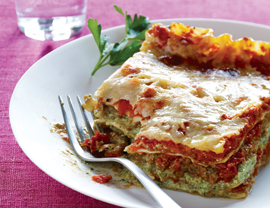

In [1]:
import theano
import theano.tensor as T
import lasagne
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
IPython.display.Image("http://static-vegetariantimes.s3.amazonaws.com/wp-content/uploads/2009/03/10851medium.jpg")

## Toy example

As a toy example to demonstrate functionality, we'll train a standard multi-layer perceptron on a simple synthetic two-dimensional four-class dataset.

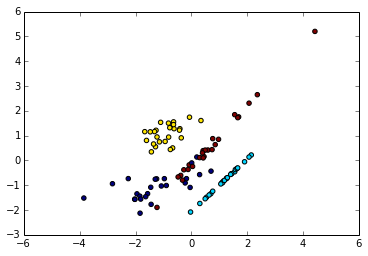

In [2]:
# Generate synthetic data
N_CLASSES = 4
X, y = sklearn.datasets.make_classification(n_features=2, n_redundant=0,
                                            n_classes=N_CLASSES, n_clusters_per_class=1)
# Convert to theano floatX
X = X.astype(theano.config.floatX)
# Labels should be ints
y = y.astype('int32')
# Make a scatter plot where color encodes class
plt.scatter(X[:, 0], X[:, 1], c=y)

### The Layer class

Much of Lasagne's functionality centers around subclasses of the `Layer` class.  A typical `Layer` subclass is an implementation of some kind of commonly used neural network layer, and contains the layer's parameters as well as methods for computing the (symbolic) output given some (symbolic) input.  Most `Layer`s are initialized with an input layer.  Constructing a network therefore typically involves instantiating `Layer` subclasses where each instance takes its input from a previous layer.  The output of the network can be generated using the final layer's `get_output` method, which recursively computes the output of all layers given an input.  The class `InputLayer` is a special layer type which stops the recurision and allows the user to input actual data into the network.

In [3]:
# First, construct an input layer.
# The shape parameter defines the expected input shape, which is just the shape of our data matrix X.
l_in = lasagne.layers.InputLayer(shape=X.shape)
# A dense layer implements a linear mix (xW + b) followed by a nonlinearity.
l_hidden = lasagne.layers.DenseLayer(
    l_in,  # The first argument is the input to this layer
    num_units=10,  # This defines the layer's output dimensionality
    nonlinearity=lasagne.nonlinearities.tanh)  # Various nonlinearities are available
# For our output layer, we'll use a dense layer with a softmax nonlinearity.
l_output = lasagne.layers.DenseLayer(l_hidden, num_units=N_CLASSES, 
                                     nonlinearity=lasagne.nonlinearities.softmax)
# Now, we can generate the symbolic expression of the network's output given an input variable.
net_input = T.matrix('net_input')
net_output = l_output.get_output(net_input)

### Training a network

Lasagne also crucially provides functionality for constructing updates to optimize the networks parameters according to some objective (i.e. train it).  This makes it easy to, for example, train a network with stochastic gradient descent (or something more fancy like AdaGrad).  Computing the updates typically involves defining a symbolic loss function, collecting the network's parameters using `get_all_params`, then using a function in `lasagne.updates`.  The resulting updates list can then be fed into a `theano.function` to train the network.

In [4]:
# As a loss function, we'll use Theano's categorical_crossentropy function.
# This allows for the network output to be class probabilities,
# but the target output to be class labels.
true_output = T.ivector('true_output')
loss = T.mean(T.nnet.categorical_crossentropy(net_output, true_output))
# Retrieving all parameters of the network is done using get_all_params,
# which recursively collects the parameters of all layers connected to the provided layer.
all_params = lasagne.layers.get_all_params(l_output)
# Now, we'll generate updates using Lasagne's SGD function
updates = lasagne.updates.sgd(loss, all_params, learning_rate=1)
# Finally, we can compile Theano functions for training and computing the output.
train = theano.function([net_input, true_output], loss, updates=updates)
get_output = theano.function([net_input], net_output)

In [5]:
# Train for 100 epochs
for n in xrange(100):
    train(X, y)

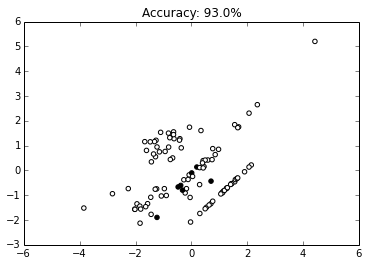

In [6]:
# Compute the predicted label of the training data.
# The argmax converts the class probability output to class label
y_predicted = np.argmax(get_output(X), axis=1)
# Plot incorrectly classified points as black dots
plt.scatter(X[:, 0], X[:, 1], c=(y != y_predicted), cmap=plt.cm.gray_r)
# Compute and display the accuracy
plt.title("Accuracy: {}%".format(100*np.mean(y == y_predicted)))

## Other useful functionality

The above example illustrates the simplest possible usage of Lasagne.  The library implements a wide variety of other useful functionality, some of which is described below.

### Initialization

The initialization used for each parameter in each layer can be a Numpy `ndarray`, a Theano shared variable, or an `Initializer` subclass from `lasagne.init`.  Many common initialization schemes are included in Lasagne for convenience.  For example, by default a `DenseLayer` initializes its weight matrix uniformly at random with a range set according to the number of incoming and outgoing connections the layer has.  If we want to initialize the weight matrix with a Gaussian random variable with a mean of 0 and standard deviation of .1, we'd do the following instead:

In [7]:
l_hidden = lasagne.layers.DenseLayer(l_in, num_units=10,
                                     W=lasagne.init.Normal(avg=0, std=.1),
                                     nonlinearity=lasagne.nonlinearities.tanh)

### Dropout

Dropout in Lasagne is implemented as a `Layer` subclass.  By placing a `DropoutLayer` between layers, the connections between the two layers will randomly be dropped.  Setting the keyword argument `deterministic` to `True` will make the `DropoutLayer` act as a simple pass-through, which is useful when computing the output of the network after training.  Adding a `DropoutLayer` between the hidden an output layer in the above example would look something like the following:

In [8]:
# Add a DropoutLayer whose input is the hidden layer
l_dropout = lasagne.layers.DropoutLayer(l_hidden,
                                        p=.5)  # Set the dropout probability
# Now, we just set the input to the output layer as the new dropout layer
l_output = lasagne.layers.DenseLayer(l_dropout, num_units=N_CLASSES, 
                                     nonlinearity=lasagne.nonlinearities.softmax)
# We should only use dropout when training
net_input = T.matrix('net_input')
net_output_train = l_output.get_output(net_input, deterministic=True)
net_output = l_output.get_output(net_input, deterministic=False)

An example of a 3-layer network trained to predict MNIST digits which utilizes dropout can be found at [`examples/mnist.py`](https://github.com/benanne/Lasagne/blob/master/examples/mnist.py) in the Lasagne source root.

### Noise

Adding Gaussian noise in the network can be an effective way to prevent overfitting.  As with dropout, this is implemented in Lasagne as a `GaussianNoiseLayer`, which is simply a `Layer` subclass which adds noise to its input.  Its usage is the same as with the `DropoutLayer` example shown above.

### Convolutional layers

Lasagne implements a variety of convolutional/pooling layers for construcing convolutional networks, including a native implementation (see [`lasagne/layers/conv.py`](https://github.com/benanne/Lasagne/blob/master/lasagne/layers/conv.py)) whose usage on MNIST classification can be seen in the [`examples/mnist_conv.py`](https://github.com/benanne/Lasagne/blob/master/examples/mnist_conv.py) example. Care has also been taken to provide wrappers for the various efficient convolutional net libraries, such as nVidia's cuDNN and cuda_convnet.  Usage examples for these two wrappers are available in [`examples/mnist_conv_dnn.py`](https://github.com/benanne/Lasagne/blob/master/examples/mnist_conv_dnn.py) and [`examples/mnist_conv_cc.py`](https://github.com/benanne/Lasagne/blob/master/examples/mnist_conv_cc.py) respectively.

### Recurrent Layers

Development of recurrent layers in Lasagne is ongoing in [this fork](https://github.com/craffel/nntools).  Currently, classes for a customizable recurrent layer an a LSTM layer have been implemented.  The layers can be set to run forwards or backwards on their input sequences.  A great deal of effort has been placed on making these layers as efficient as possible, although at present the LSTM layer is still slower than `currennt`, a CUDA-based library.